In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
import networkx as nx

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
## Load necessary data
G = pickle.load(open('data/revised_cleaning_results/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/revised_cleaning_results/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

In [3]:
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
 

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [4]:
nodes_to_keep = df_nodes.loc[(df_nodes.degree!=2)|(df_nodes.n.isin(harbour_nodes))]

In [5]:
keep = list(nodes_to_keep.n)+['8866429']

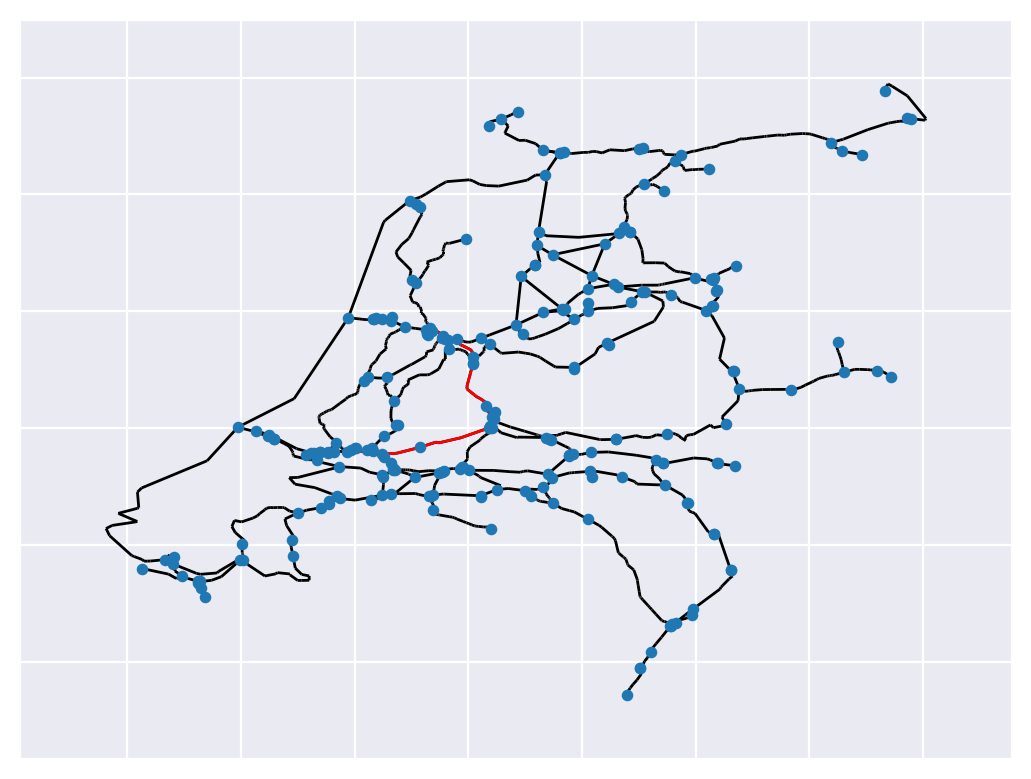

In [6]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)
H = G.subgraph(paths[('NLRTM', 'NLAMS', 1)])
nx.draw_networkx_edges(H, pos_dict, edge_color='r')
plt.show()

In [7]:
# create list to store new edges
new_edges = []

#loop over all routes
for key, route in paths.items():
    path_length = 0
    print(key)
    # store all nodes that are still in G in the right order

    new_route = []
    for node in route:
        if node in keep:
            new_route.append(node)

    # change path to new route already
    paths[key] = new_route
    print(new_route)
    sub_trips = [new_route[i:(i+2)] for i in range(len(new_route)-1)]
    print(sub_trips)
    started_from = new_route[0]
    for sub_trip in sub_trips:
        origin=sub_trip[0]
        destination=sub_trip[1]
        path_length += nx.dijkstra_path_length(G, origin, destination, weight='length_m')
        if destination in new_route:
            if G.has_edge(started_from, destination):
                started_from = destination
                path_length = 0
            else:
                new_edges.append((origin, destination, path_length))
                started_from = destination
                path_length = 0

    # # create a dict with routes between node to keep to next node to keep
    # sub_routes = {i:[] for i in range(len(new_route)-1)}
    # print(sub_routes)
    # # current sub route
    # r = 0
    # # loop over all nodes of route
    # for i, node in enumerate(route):
    #     # divide nodes over different sub_routes
    #     sub_routes[r].append(node)
    #     # if node final node of sub_route is encountered: add this node to next route and fill this one from now on
    #     if (node in keep) and (i>0) and (node != route[-1]):
    #         sub_routes[r+1].append(node)
    #         r+=1
    # for sub_route in sub_routes.values():
    #     path_length = 0
    #     # print(sub_route)
    #     if len(sub_route) > 2:
    #         path_length = 0
    #         for j in range(len(sub_route)-1):
    #             path_length += nx.dijkstra_path_length(G, sub_route[j], sub_route[j+1], weight='length_m')
    #         new_edges.append((sub_route[0], sub_route[-1], path_length))
    #     else:
    #         path_length += nx.dijkstra_path_length(G, sub_route[0], sub_route[1], weight='length_m')
    #         new_edges.append((sub_route[0], sub_route[-1], path_length))
    # for i in range(len(new_route)-1):
    #     new_edges.append((new_route[i],new_route[i+1],path_l))


('NLABL', 'NLRTM', 0)
['8866686', '8865140', '8867500', '8863742', '8864009', '8863306']
[['8866686', '8865140'], ['8865140', '8867500'], ['8867500', '8863742'], ['8863742', '8864009'], ['8864009', '8863306']]
('NLAER', 'NLLEY', 0)
['8864005', '8864526', '8862690', '8863709']
[['8864005', '8864526'], ['8864526', '8862690'], ['8862690', '8863709']]
('NLAER', 'NLNIE', 0)
['8864005', '8864076', '8867515', '8864384', '8862592', '8867046', '8863360', '8865214', '8867538']
[['8864005', '8864076'], ['8864076', '8867515'], ['8867515', '8864384'], ['8864384', '8862592'], ['8862592', '8867046'], ['8867046', '8863360'], ['8863360', '8865214'], ['8865214', '8867538']]
('NLAER', 'NLRTM', 0)
['8864005', '8864076', '8867515', '8864384', '8862592', '8867046', '8863360', '8865214', '8867538', '8867374', '8863742', '8864009', '8863306']
[['8864005', '8864076'], ['8864076', '8867515'], ['8867515', '8864384'], ['8864384', '8862592'], ['8862592', '8867046'], ['8867046', '8863360'], ['8863360', '8865214'], 

In [8]:
G = G.subgraph(keep)
G = nx.Graph(G)
G.add_weighted_edges_from(new_edges,'length_m')

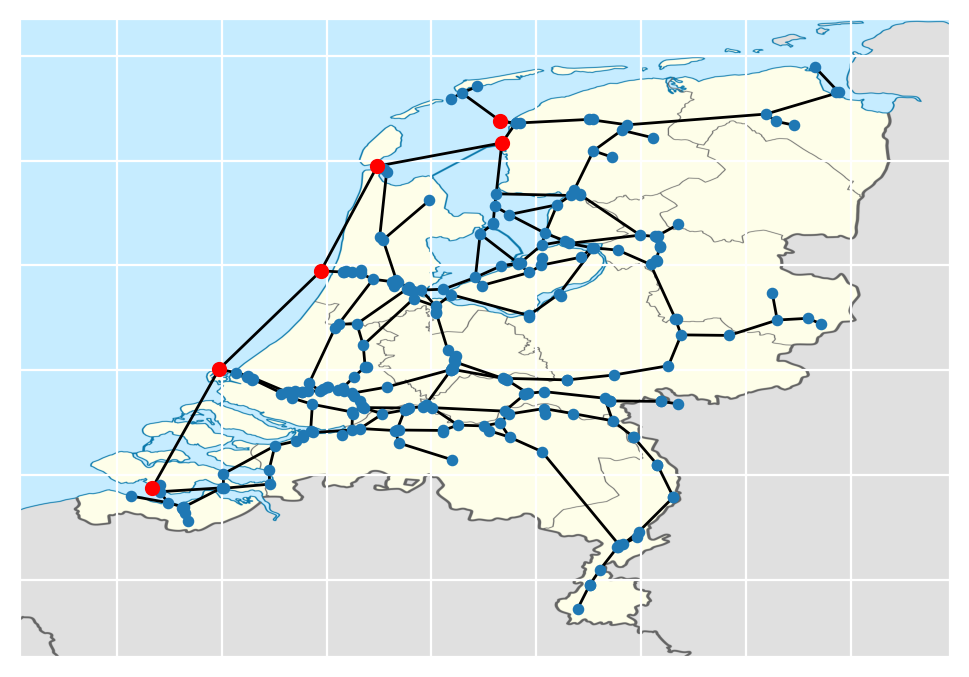

In [9]:
fig, ax = plt.subplots(dpi=200, figsize=(6,6))
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)
nx.draw_networkx_nodes(G, pos_dict, ['8862614', '8860852', '8861819','8867031','8867600', '8860933'], node_color='r', node_size=20)
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])

In [10]:
# store this network with direct connections for later use
pickle.dump(G, open('data/network_cleaned_final.p', 'wb'))
pickle.dump(paths, open('data/final_paths.p', 'wb'))

In [11]:
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [12]:
df_links.loc[(df_links.source=='8860852')]

,source,target,WidePushedDepth,SeaFairingWidth,StartJunctionId,Description,WidePushedLength,GeneralLength,WidePushedWidth,Length,...,length_m,SeaFairingLength,CoupledLength,PushedLength,Wkt,PushedWidth,Id_navigability,Code,EndJunctionId,Classification
158,8860852,8861819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77157.83409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_links

,source,target,WidePushedDepth,SeaFairingWidth,StartJunctionId,Description,WidePushedLength,GeneralLength,WidePushedWidth,Length,...,length_m,SeaFairingLength,CoupledLength,PushedLength,Wkt,PushedWidth,Id_navigability,Code,EndJunctionId,Classification
0,8862506,8861968,NaN,NaN,8861968,NaN,NaN,NaN,NaN,0.409,...,494.878279,NaN,NaN,NaN,"LINESTRING (6.0721412574178 52.5251283346527, ...",NaN,29514761.0,V_A,8862506,CEMT
1,8864929,8864319,3.0,NaN,8864319,"Groot Rijnschip, Eenbaksduwstel",NaN,137.5,NaN,1.412,...,2072.412144,NaN,NaN,193.0,"LINESTRING (5.89694167558212 51.1638894365466,...",13.5,52183.0,V_A,8864929,CEMT
2,8864929,8864825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10568.213168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8864929,8862448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9622.681016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8863891,8863105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8196.865760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,22637863,8860623,NaN,NaN,22637863,NaN,NaN,NaN,NaN,0.077,...,92.322379,NaN,NaN,NaN,"LINESTRING (6.15459260200039 51.3937774485801,...",NaN,25487687.0,V_A,8860623,CEMT
285,8868208,8861292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15305.284317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,8864319,8861292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1563.896825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,8861546,8863207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37699.722135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# give edges a new attribute split
nx.set_edge_attributes(G, 0, 'split')

In [15]:
# first inserted node gets ID 100 and from there upwards
id_count = 100
inserted = []
nodes_to_add = 40
while len(inserted) < nodes_to_add:
    # update dataframes
    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

    exluded_nodes = ['8862614', '8860852', '8861819','8867031','8867600', '8860933']
    # find the longest link source and origin, except for the two links that cross the sea
    df_links = df_links.loc[(~df_links.source.isin(exluded_nodes))|(~df_links.target.isin(exluded_nodes))]
    df_links.reset_index(inplace=True, drop=True)
    to_split = df_links.loc[df_links.length_m == max(df_links.length_m)]
    to_split.reset_index(inplace=True, drop=True)
    # identify source/targets points
    points = list(to_split.loc[(to_split.source.str.len()>5)].source.values) + list(to_split.loc[(to_split.target.str.len()>5)].target.values)
    print(points)
    org_source = points[0]
    org_target = points[1]
    print('Largest link found', to_split.length_m[0], 'original link:', org_source, org_target, 'splitted', to_split.split[0], 'times before.')

    # determine original length, also works if link has been split earlier
    original_length = 0
    for j in to_split.length_m:
        original_length += j

    org_source_data = df_nodes.loc[df_nodes.n == org_source]
    org_target_data = df_nodes.loc[df_nodes.n == org_target]

    #if never split: split in two, if split once: split in three, etc.
    split_in = round(to_split.split[0] + 2)

    #find new X and Y positions
    x_set = np.linspace(org_source_data.X.values[0], org_target_data.X.values[0], (split_in+1))
    y_set = np.linspace(org_source_data.Y.values[0], org_target_data.Y.values[0], (split_in+1))

    # remove old link(s)
    for j in to_split.index:
        G.remove_edge(to_split.source[j], to_split.target[j])
        print('Link removed between', to_split.source[j], to_split.target[j])
    #if split before, remove earlier inserted points
    points_to_remove = list(to_split.loc[(to_split.source.str.len()<5)].source.values) + list(to_split.loc[(to_split.target.str.len()<5)].target.values)
    if points_to_remove:
        for j in set(points_to_remove):
            G.remove_node(j)
            print("Node", j, "removed and replaced by", split_in-1,"intermediate nodes")
            inserted.remove(j)


    # add nodes, except for outsides that already exist
    added_ids = []
    print(x_set)
    print(y_set)
    for index_pos, j in enumerate(x_set):
        if (index_pos != 0) and (index_pos != (len(x_set)-1)):
            G.add_node(str(id_count), X = x_set[index_pos], Y = y_set[index_pos])
            print('Node inserted with id', id_count, 'at (x,y):', x_set[index_pos], y_set[index_pos])
            added_ids.append(str(id_count))
            inserted.append(str(id_count))
            id_count += 1

    #finally, add edges
    nodes_sequence = [org_source] + added_ids + [org_target]
    print(nodes_sequence)
    for j in range(len(nodes_sequence)-1):
        G.add_edge(nodes_sequence[j],nodes_sequence[j+1], length_m=(original_length/split_in), split = int(to_split.split[0]+1))
        print("Link added between", nodes_sequence[j], nodes_sequence[j+1], "with length", (original_length/split_in))

    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
else:
    print("There were", len(inserted), "nodes added, the longest remaining link is now:", df_links.length_m.max())

['8861681', '8862419']
Largest link found 75895.64343792459 original link: 8861681 8862419 splitted 0 times before.
Link removed between 8861681 8862419
[5.93422443 6.26537212 6.5965198 ]
[53.17037604 53.19608016 53.22178428]
Node inserted with id 100 at (x,y): 6.2653721173492 53.19608015887845
['8861681', '100', '8862419']
Link added between 8861681 100 with length 37947.821718962296
Link added between 100 8862419 with length 37947.821718962296
['8865990', '8864319']
Largest link found 68798.30264237327 original link: 8865990 8864319 splitted 0 times before.
Link removed between 8865990 8864319
[5.52766808 5.71230488 5.89694168]
[51.61068606 51.38728775 51.16388944]
Node inserted with id 101 at (x,y): 5.712304877163126 51.38728774858195
['8865990', '101', '8864319']
Link added between 8865990 101 with length 34399.15132118663
Link added between 101 8864319 with length 34399.15132118663
['8861380', '8865869']
Largest link found 54207.89577528922 original link: 8861380 8865869 splitted 

In [16]:
# fix insertion of additional nodes in route!
for route, path in paths.items():
    new_route = [path[0]]
    for node_index in range(len(path)-1):
        p = nx.dijkstra_path(G, path[node_index], path[node_index+1])
        new_route += p[1:]
    paths[route] = new_route

In [17]:
# retrieve data again
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

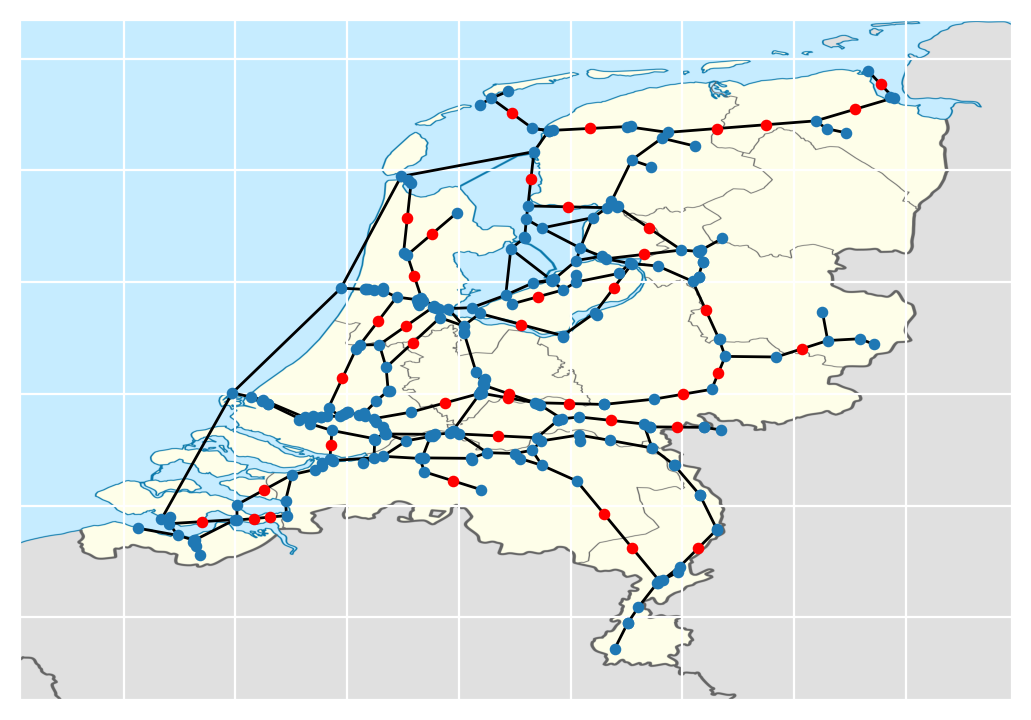

In [18]:
#check if it worked
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)

nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)
nx.draw_networkx_nodes(G, pos_dict, inserted, node_size=10, node_color='r')
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
# nx.draw_networkx_nodes(G, pos_dict, ['8866429'], node_size=10, node_color='g')

## Final step: test new network with optimisation

In [21]:
path_lengths

{('NLABL', 'NLRTM', 0): 16466.656233704023,
 ('NLAER', 'NLLEY', 0): 39564.79886419149,
 ('NLAER', 'NLNIE', 0): 118223.88184524442,
 ('NLAER', 'NLRTM', 0): 140247.87034164183,
 ('NLAER', 'NLSWI', 0): 57828.9740807698,
 ('NLALK', 'NLIJM', 0): 64164.295854298245,
 ('NLALM', 'NLAMS', 0): 284879.61630180234,
 ('NLALM', 'NLHGL', 0): 31577.230532179885,
 ('NLAMS', 'NLAER', 0): 57028.24101311254,
 ('NLAMS', 'NLBON', 0): 251972.1205547219,
 ('NLAMS', 'NLBON', 1): 293406.1555796675,
 ('NLAMS', 'NLBOT', 0): 120855.00610801627,
 ('NLAMS', 'NLBOT', 1): 127979.94054697432,
 ('NLAMS', 'NLBOT', 2): 134496.18503207507,
 ('NLAMS', 'NLBOT', 3): 160000.1534067007,
 ('NLAMS', 'NLBOT', 4): 170830.7943424132,
 ('NLAMS', 'NLDEV', 0): 202008.570687923,
 ('NLAMS', 'NLDHR', 0): 85685.78071239138,
 ('NLAMS', 'NLEEM', 0): 330195.5202462655,
 ('NLAMS', 'NLENS', 0): 293538.3700023955,
 ('NLAMS', 'NLEUR', 0): 137581.65518691286,
 ('NLAMS', 'NLEUR', 1): 195348.12629869088,
 ('NLAMS', 'NLHEJ', 0): 184057.99110039146,
 

In [19]:
from random_vessel_generator import random_vessel_generator
from flow_computation import flow_computation
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from visualize_placement import visualize_placement

In [20]:
#generate random data
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)
flows = flow_computation(df_random1)

## Run first stage FRLM
df_b, df_g, df_eq_fq = first_stage_frlm(50000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted)

## Run second stage FRLM
optimal_facilities, optimal_flows, non_zero_flows, supported_flow = second_stage_frlm(100, 10, 5, df_g, df_b, df_eq_fq)

visualize_placement(G, flows, optimal_facilities, non_zero_flows, df_h, paths, unused=True)

ZeroDivisionError: division by zero